### RWSE-Checker: false-positives (false alarm) statistics from filtered corpus

In [14]:
from cassis import Cas, load_typesystem
from rwse import RWSE_Checker
from util.helper import collect_sentences_by_confusion_sets, normalize_report

import matplotlib.pyplot as plt
import numpy as np
import os
import spacy

In [2]:
rwse = RWSE_Checker()
rwse.set_confusion_sets('input/confusion_sets_modified.csv')

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls

#### Load sentences by confusion sets

In [3]:
file_name = 'input/eng_news_2023-balanced-sentences.csv'

with open(file_name, 'r') as f:
    sentences = f.readlines()

sentences_cleaned = [sentence.split('\t')[1].strip() for sentence in sentences]

nlp = spacy.load('en_core_web_sm')
sentences_by_confusion_sets = collect_sentences_by_confusion_sets(rwse.confusion_sets.values(), sentences_cleaned,nlp)

total = 0

for key, value in sorted(sentences_by_confusion_sets.items()):
    total += len(value)
    print(key, '=', len(value))

print('total =', total)

Being,begin,being = 213
Capital,Capitol,capital = 111
Country,County,country,county = 168
Desert,desert,dessert = 101
Easy,ease,easy = 111
Effect,affect,effect = 118
Effects,affects,effects = 105
Except,accept,except = 105
Few,View,few,view = 168
Form,From,form,from = 643
Found,Fund,found,fund = 160
Fourth,forth,fourth = 117
Hole,Whole,hole,whole = 110
Lead,Led,lead,led = 146
Life,Live,life,live = 172
Mad,Made,mad,made = 169
Or,or,ore = 325
Past,passed,past = 127
Peace,Piece,peace,piece = 109
Plain,plain,plane = 104
Principal,principal,principle = 102
Provence,Province,province = 101
Quiet,Quite,quiet,quite = 110
Rise,raise,rise = 105
Safe,Save,safe,save = 120
Site,sight,site = 116
Split,spit,split = 101
Than,Then,than,then = 276
Their,There,They,their,there,they = 654
Them,Theme,them,theme = 178
Things,things,thinks = 115
Three,Tree,three,tree = 166
To,Too,Two,to,too,two = 2463
Trail,Trial,trail,trial = 109
Weather,Whether,weather,whether = 119
Week,weak,week = 151
Were,Where,were,whe

#### Determine RWSEs

In [4]:
T_SENTENCE = 'de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Sentence'
T_RWSE = 'de.tudarmstadt.ukp.dkpro.core.api.anomaly.type.RWSE'
T_TOKEN = 'de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Token'

nlp = spacy.load('en_core_web_sm')

path = 'input/TypeSystem.xml'

with open(path, 'rb') as f:
    ts = load_typesystem(f)

S = ts.get_type(T_SENTENCE)
T = ts.get_type(T_TOKEN)

In [10]:
file_name = 'output/report_false_positives_balanced.csv'

result = dict()

if not os.path.exists(file_name):

    with open('output/false_positives_balanced.csv', 'w') as f:

        for confusion_set, sentences in sentences_by_confusion_sets.items():
            matches = 0
            rwse.set_confusion_sets([set(confusion_set.split(','))])
            for sentence in sentences:
                cas = Cas(ts)
                # TODO clean sentence?
                cas.sofa_string = sentence
                doc = nlp(cas.sofa_string)
                cas_sentence = S(begin=0, end=len(sentence))
                cas.add(cas_sentence)
                for token in doc:
                    cas_token = T(begin=token.idx, end=token.idx+len(token.text), id=token.i)
                    cas.add(cas_token)
                rwse.check_cas(cas, ts)
                false_positives = cas.select(T_RWSE)
                if len(false_positives) != 0:
                    matches += 1
                    for item in false_positives:
                        before = cas.sofa_string[item.begin:item.end]
                        modified_string = cas.sofa_string[:item.begin] + ' [[' + cas.sofa_string[item.begin:item.end] + ']] ' +cas.sofa_string[item.end:]
                        print(f'{before} => {item.suggestion}' ,f'({item.certainty:.5f})' , modified_string, sep='\t', file=f)
            result[confusion_set] = {
                'num_sentences':len(sentences),
                'num_matches':matches,
            }
    with open(file_name, 'w') as f:
        print('confusion_set', 'num_matches', 'num_sentences', sep=';', file=f)
        for key, value in result.items():
            print(key, value['num_matches'], value['num_sentences'], sep=';', file=f)
else:
    with open(file_name, 'r') as f:
        for line in f.readlines()[1:]:
            confusion_set, num_matches, num_sentences = line.strip().split(';')
            print(confusion_set, num_matches, num_sentences, sep='\t', end='\n')
            result[confusion_set] = {'num_matches': int(num_matches), 'num_sentences': int(num_sentences)}


Except,accept,except	0	105
advice,advise	4	102
Effect,affect,effect	2	118
Being,begin,being	0	213
bitch,pitch	1	102
brakes,breaks	2	101
Capital,Capitol,capital	2	111
Site,sight,site	0	116
Country,County,country,county	0	168
crab,crap	1	100
Desert,desert,dessert	0	101
Easy,ease,easy	0	111
Effects,affects,effects	0	105
extend,extent	1	101
feat,feet	0	111
Few,View,few,view	0	168
Form,From,form,from	1	643
Fourth,forth,fourth	0	117
forms,forums	0	101
Found,Fund,found,fund	0	160
Lead,Led,lead,led	2	146
Life,Live,life,live	2	172
loose,lose	0	102
Mad,Made,mad,made	0	169
Or,or,ore	2	325
Past,passed,past	1	127
Peace,Piece,peace,piece	2	109
Plain,plain,plane	0	104
Principal,principal,principle	1	102
Provence,Province,province	1	101
Quiet,Quite,quiet,quite	1	110
Rise,raise,rise	2	105
Safe,Save,safe,save	1	120
Split,spit,split	1	101
Than,Then,than,then	0	276
Their,There,They,their,there,they	3	654
Them,Theme,them,theme	1	178
Things,things,thinks	0	115
Trail,Trial,trail,trial	2	109
Three,Tree,three,

#### Determine false-positive rate

In [26]:
total = sum(item['num_sentences'] for item in result.values())
total_matches = sum(item['num_matches'] for item in result.values())
print(f'false positive rate: {total_matches/total:.3f}')
print(f'falsely identified {total_matches} out of {total}')

false positive rate: 0.005
falsely identified 54 out of 11316


### Determine mean false-positive rate

In [12]:
file_name = 'output/report_false_positives_balanced.csv'

data_mean_fpr = normalize_report(file_name)

mean_fpr = sum(data_mean_fpr.values())/ len(data_mean_fpr)

print(f'Mean False-Positive-Rate = {mean_fpr:.10f}')

Except,accept,except: 0.0000000000
advice,advise: 0.0392156863
Effect,affect,effect: 0.0169491525
Being,begin,being: 0.0000000000
bitch,pitch: 0.0098039216
brakes,breaks: 0.0198019802
Capital,Capitol,capital: 0.0180180180
Site,sight,site: 0.0000000000
Country,County,country,county: 0.0000000000
crab,crap: 0.0100000000
Desert,desert,dessert: 0.0000000000
Easy,ease,easy: 0.0000000000
Effects,affects,effects: 0.0000000000
extend,extent: 0.0099009901
feat,feet: 0.0000000000
Few,View,few,view: 0.0000000000
Form,From,form,from: 0.0015552100
Fourth,forth,fourth: 0.0000000000
forms,forums: 0.0000000000
Found,Fund,found,fund: 0.0000000000
Lead,Led,lead,led: 0.0136986301
Life,Live,life,live: 0.0116279070
loose,lose: 0.0000000000
Mad,Made,mad,made: 0.0000000000
Or,or,ore: 0.0061538462
Past,passed,past: 0.0078740157
Peace,Piece,peace,piece: 0.0183486239
Plain,plain,plane: 0.0000000000
Principal,principal,principle: 0.0098039216
Provence,Province,province: 0.0099009901
Quiet,Quite,quiet,quite: 0.00

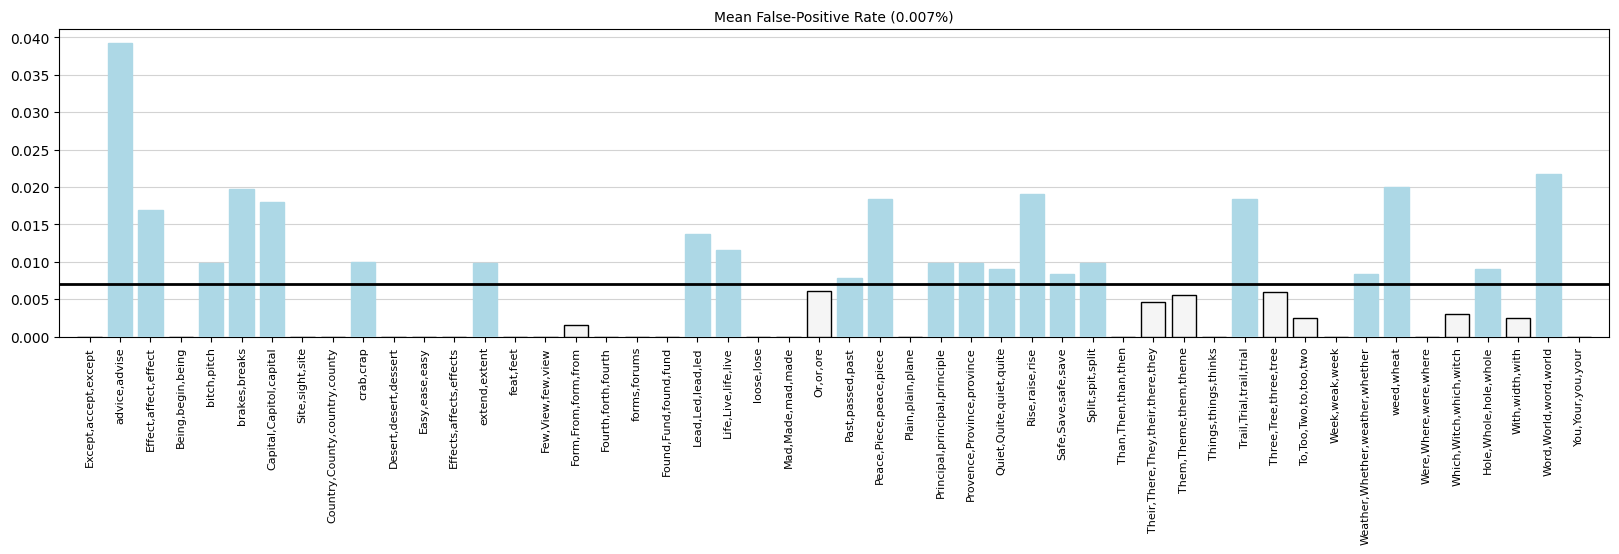

In [20]:
xticks = list(range(len(data_mean_fpr)))
values = list(data_mean_fpr.values())
labels = list(data_mean_fpr.keys())

fig, ax = plt.subplots(figsize=(20,4))
ax.set_title(f"Mean False-Positive Rate ({mean_fpr:.3f}%)", fontsize=10)
bars = ax.bar(xticks, values, zorder=3, color="whitesmoke", edgecolor="black", linewidth=1, align="center")
for idx, value in enumerate(values):
    if value > mean_fpr:
        bars[idx].set_color('lightblue')
ax.set_xticks(xticks, labels, rotation='vertical')
ax.xaxis.set_tick_params(labelsize=8)
ax.grid(color='lightgray', axis="y", zorder=0)
ax.margins(x=0) # removes white space surrounding bars

x = np.linspace(-1, len(data_mean_fpr))
y = [mean_fpr]*len(x)
ax.plot(x, y, zorder=3, color="black", linewidth=2)

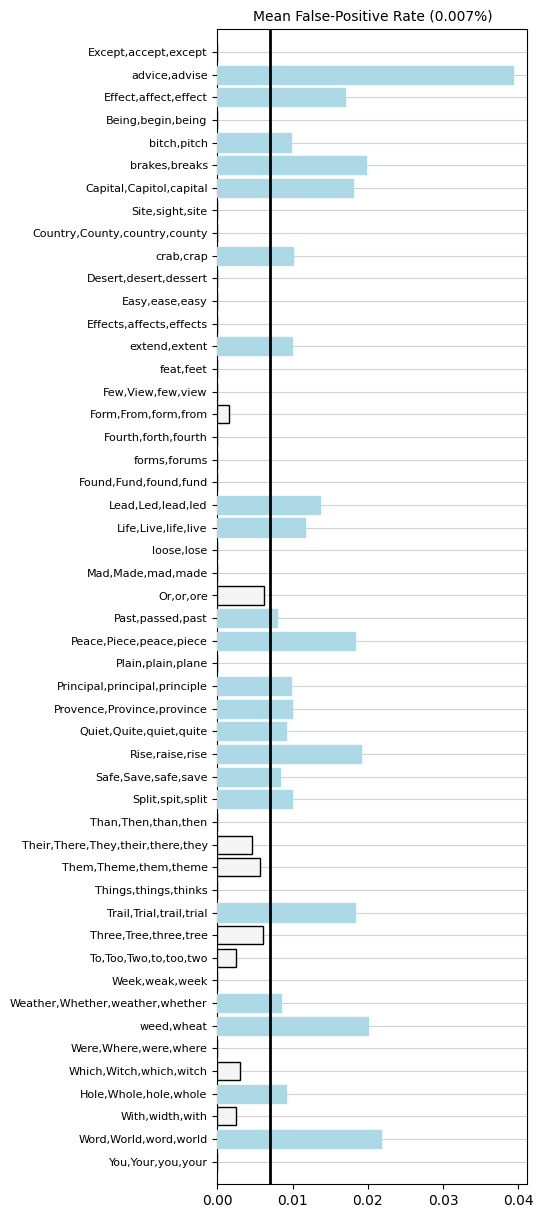

In [23]:
yticks = list(range(len(data_mean_fpr)))
values = list(data_mean_fpr.values())
labels = list(data_mean_fpr.keys())

values.reverse()
labels.reverse()

fig, ax = plt.subplots(figsize=(4,15))
ax.set_title(f"Mean False-Positive Rate ({mean_fpr:.3f}%)", fontsize=10)
bars = ax.barh(yticks, values, zorder=3, color="whitesmoke", edgecolor="black", linewidth=1, align="center")
for idx, value in enumerate(values):
    if value > mean_fpr:
        bars[idx].set_color('lightblue')
ax.set_yticks(yticks, labels, rotation='horizontal')
ax.yaxis.set_tick_params(labelsize=8)
ax.grid(color='lightgray', axis="y", zorder=0)
ax.margins(y=0)

x = [mean_fpr]*len(x)
y = np.linspace(-1, len(data_mean_fpr))
ax.plot(x, y, zorder=3, color="black", linewidth=2)